In [1]:
# manually set mode to 64 bits (if desired)
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# import the usual libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from matplotlib.colors import LogNorm

In [3]:
import cyjax

In [4]:
# random number sequence
rns = cyjax.util.PRNGSequence(42)

# Donaldson's algorithm & volume

As a first application, let us estimate the volume by MC integration. 
Optionally, an estimate for the variance can also be computed (based on the variance of the integrand).

In [5]:
dwork = cyjax.Dwork(3)    # single parameter family
psi = jnp.array([10+3j])  # pick some moduli values

In [6]:
volcy, volcy_var = dwork.compute_vol(next(rns), psi, batch_size=500, var=True)
print('%.3f ± %.3f' % (volcy, jnp.sqrt(volcy_var)))

0.949 ± 0.001


In [7]:
volcy, volcy_var = dwork.compute_vol(next(rns), psi, batch_size=2000, var=True)
print('%.3f ± %.3f' % (volcy, jnp.sqrt(volcy_var)))

0.947 ± 0.001


## Polynomial basis on variety

For Donaldson's algorithm, we need to choose a basis of the line bundle of chosen degree on the variety.
We cannot directly use the full set of monomials in ambient projective space since they are not independent on the variety (where any linear combination proportional to the defining polynomial vanishes).
A basic (but not necessarily numerically optimal) algorithm for a reduced basis is implemented.
Other methods can be added by creating a new subclass of `cyjax.donaldson.LBSections`.

In [8]:
degree = 5  # use homogeneous polynomials of this degree for embedding

Size of polynomial space on full ambient projective space:

In [9]:
mon_basis = cyjax.donaldson.MonomialBasisFull(dwork.dim_projective, degree)
mon_basis.size

126

Donaldson's algorithm requires a basis on the variety 
(which is reduced if the degree is at least as large as the defining polynomial degree):

In [10]:
mon_basis = cyjax.donaldson.MonomialBasisReduced(dwork, degree, psi)
mon_basis.size

125

In [11]:
# for `MonomialBasisReduced`, the underlying data structure is a power matrix
mon_basis.power_matrix.shape

(125, 5)

## Donaldson's algorithm

In [12]:
degree = 4
mon_basis = cyjax.donaldson.MonomialBasisReduced(dwork, degree, psi)

Based on the monomial basis, we instantiate the algebraic metric object which collects the different components and exposes functions for convenience.

In [13]:
metric = cyjax.donaldson.AlgebraicMetric(dwork, mon_basis)

In [14]:
# an estimate for how many MC sample points to use in integral
n_samples = (10 * mon_basis.size**2 + 50000) // 5

# compute MC integral in batches with a fixed batch size
# otherwise would run out of memory for larger degrees
batch_size = 1000

batches = n_samples // batch_size + 1
n_samples = batches * batch_size
batches, n_samples

(20, 20000)

In [15]:
# initial value of H-matrix
h = jnp.eye(mon_basis.size, dtype=complex)

In [16]:
# To speed up computation, we JIT-compile the step with hyperparameters fixed
donaldson = jax.jit(partial(
    metric.donaldson_step,
    params=psi, vol_cy=volcy, batches=batches, batch_size=batch_size))

In [17]:
niter = 15  # do 15 iterations of T operator

h_iter = h

for i in range(niter):
    h_iter = (h_iter + h_iter.conj().T) / 2  # assure h is Hermitian
    h_iter = donaldson(next(rns), h_iter)
    h_iter = h_iter / jnp.max(jnp.abs(h_iter))

In [18]:
# final eta accuracy
metric.sigma_accuracy(next(rns), psi, h_iter, 1000).item()

0.1556105662052128

In [19]:
# compared to initial accuracy
metric.sigma_accuracy(next(rns), psi, h, 1000).item()

0.7253018887348935

## Example: scan for Fermat quintic

In [20]:
fermat = cyjax.Fermat(3)
psi = None

volcy = fermat.compute_vol(next(rns), psi, batch_size=2000)

In [21]:
from tqdm.notebook import tqdm

In [22]:
niter = 10  # set to 15 for better results

degrees = np.arange(1, 6)
accuracies = []

for degree in degrees:
    mon_basis = cyjax.donaldson.MonomialBasisReduced(fermat, degree, None)
    metric = cyjax.donaldson.AlgebraicMetric(fermat, mon_basis)
    
    n_samples = (10 * mon_basis.size**2 + 50000) // 5
    batch_size = 1000
    batches = n_samples // batch_size + 1
    
    donaldson = jax.jit(partial(
        metric.donaldson_step,
        params=psi, vol_cy=volcy, batches=batches, batch_size=batch_size))

    h = jnp.eye(metric.sections.size, dtype=complex)

    for i in range(niter):
        h = donaldson(next(rns), h)
        h = h / jnp.max(jnp.abs(h))
        
    acc = metric.sigma_accuracy(next(rns), psi, h, 1000).item()
    accuracies.append(acc)

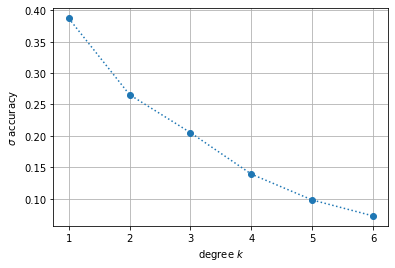

In [23]:
plt.plot(degrees, accuracies, 'o:')
plt.grid(which='both')
plt.xlabel('degree $k$')
plt.ylabel(r'$\sigma$ accuracy')
plt.show()